In [101]:
from pathlib import Path
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import numpy as np
from scipy.optimize import curve_fit

In [221]:
xray_stat_dfs, rmsd_stat_dfs = list(), list()

target = "7mhf"
job_name = "123_natives_2_state"

# score_field = "xray_0+xray_1"
# rmsd_field = "rmsd_0+rmsd_1"

score_field = "xray_0"
rmsd_field = "rmsd_0"

xray_dir = Path(Path.home(), "Documents/xray")
log_stats_dir = Path(xray_dir, "sample_bench/data", target)

for i in range(10):
    xray_stat_df = pd.read_csv(Path(log_stats_dir, job_name, "xray_volume_bench_{}.csv".format(i)), index_col=0)
    rmsd_stat_df = pd.read_csv(Path(log_stats_dir, job_name, "rmsd_volume_bench_{}.csv".format(i)), index_col=0)

    if rmsd_field == "rmsd_0+rmsd_1":
        xray_stat_df[rmsd_field+"_mean"] = xray_stat_df[rmsd_field+"_mean"] / 2
        rmsd_stat_df[rmsd_field+"_mean"] = rmsd_stat_df[rmsd_field+"_mean"] / 2

    xray_stat_dfs.append(xray_stat_df)
    rmsd_stat_dfs.append(rmsd_stat_df)

In [222]:
all_mins, all_maxes = list(), list()
for xray_stat_df in xray_stat_dfs:
    all_mins.append(xray_stat_df["{}_mean".format(score_field)].min())
    all_maxes.append(xray_stat_df["{}_mean".format(score_field)].max())
print(np.min(all_mins), np.max(all_maxes))

all_mins, all_maxes = list(), list()
for xray_stat_df in xray_stat_dfs:
    all_mins.append(xray_stat_df["{}_mean".format(rmsd_field)].min())
    all_maxes.append(xray_stat_df["{}_mean".format(rmsd_field)].max())
print(np.min(all_mins), np.max(all_maxes))

all_mins, all_maxes = list(), list()
for rmsd_stat_df in rmsd_stat_dfs:
    all_mins.append(rmsd_stat_df["{}_mean".format(rmsd_field)].min())
    all_maxes.append(rmsd_stat_df["{}_mean".format(rmsd_field)].max())
print(np.min(all_mins), np.max(all_maxes))


5.138857268121757 5.516807758457557
0.1829824356423719 0.2648209129292357
0.1730805740854769 0.2551246656952781


In [223]:
all_score_df = pd.concat(xray_stat_dfs)
all_rmsd_df = pd.concat(rmsd_stat_dfs)

score_min = all_score_df["{}_mean".format(score_field)].min()
score_max = all_score_df["{}_mean".format(score_field)].max()

score_rmsd_min = all_score_df["{}_mean".format(rmsd_field)].min()
score_rmsd_max = all_score_df["{}_mean".format(rmsd_field)].max()

rmsd_min = all_rmsd_df["{}_mean".format(rmsd_field)].min()
rmsd_max = all_rmsd_df["{}_mean".format(rmsd_field)].max()


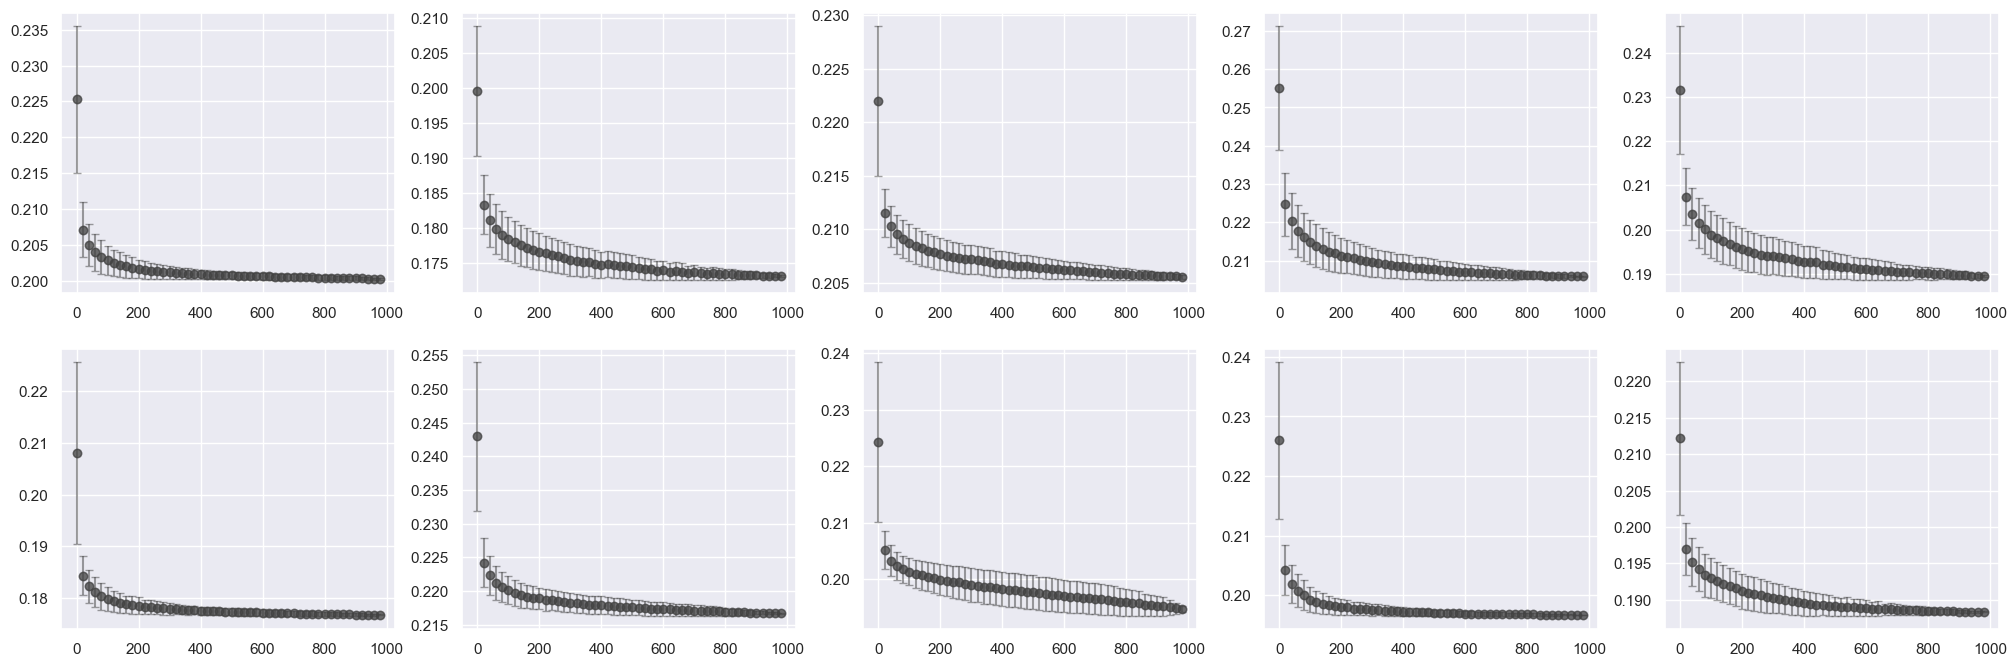

In [224]:
fig, axs = plt.subplots(2, 5, figsize=(25,8))

colors = list()
colors.append(mcolors.CSS4_COLORS["dodgerblue"])
colors.append(mcolors.CSS4_COLORS["orange"])
colors.append(mcolors.CSS4_COLORS["orangered"])

alpha = .5
space = 20

x = list(range(1000))[::space]

for i in range(10):
    y1 = xray_stat_dfs[i]["{}_mean".format(score_field)][::space]
    std1 = xray_stat_dfs[i]["{}_std".format(score_field)][::space]

    y2 = xray_stat_dfs[i]["{}_mean".format(rmsd_field)][::space]
    std2 = xray_stat_dfs[i]["{}_std".format(rmsd_field)][::space]

    y3 = rmsd_stat_dfs[i]["{}_mean".format(rmsd_field)][::space]
    std3 = rmsd_stat_dfs[i]["{}_std".format(rmsd_field)][::space]

    ax1 = axs[i//5][i%5]
    # ax1.set_ylim(score_min-.05, score_max+.05)
    # ax1.scatter(x[:len(y1)], y1, c="#424242ff", alpha=alpha)
    # ax1.errorbar(x[:len(y1)], y1, std1, linestyle='None', marker='o', capsize=3, c="#424242ff", alpha=alpha)

    # ax1.scatter(x[:len(y2)], y2, c="#424242ff", alpha=alpha)
    # ax1.errorbar(x[:len(y2)], y2, std2, linestyle='None', marker='o', capsize=3, c="#424242ff", alpha=alpha)

    ax1.scatter(x[:len(y3)], y3, c="#424242ff", alpha=alpha)
    ax1.errorbar(x[:len(y3)], y3, std3, linestyle='None', marker='o', capsize=3, c="#424242ff", alpha=alpha)

    # ax2 = ax1.twinx()
    # # ax2.set_ylim(score_rmsd_min-.02, score_rmsd_max+.02)
    # ax2.scatter(x[:len(y2)], y2, c="#424242ff", alpha=alpha)
    # ax2.errorbar(x[:len(y2)], y2, std2, linestyle='None', marker='o', capsize=3, c="#424242ff", alpha=alpha)


plt.savefig(Path(Path.home(), "Desktop/sample_volume_benchmark.png"))




### Compute convergence minimas.

In [225]:
best_scores = list()
best_accs = list()
for i in range(len(xray_stat_dfs)):
    best_scores.append(xray_stat_dfs[i].iloc[-1]["{}_mean".format(score_field)])
    best_accs.append(rmsd_stat_dfs[i].iloc[-1]["{}_mean".format(rmsd_field)])

print(np.mean(best_scores), np.std(best_scores))
print(np.mean(best_accs), np.std(best_accs))

5.3308818058249825 0.10501533317509545
0.19474465376048886 0.012727544004086556


### Compute convergence points.

In [226]:
# Define the model function for power law decay with an additional c parameter
def power_law_decay(x, a, b, c):
    return a * np.power(x, b) + c

# Define a function to perform the curve fitting for the power law decay model
def fit_power_law_decay(xs, ys):
    # Make an initial guess for the parameters
    # a: scale factor, b: exponent, c: y-axis shift
    initial_guess = [np.max(ys), -1.0, np.min(ys)]

    # Perform the curve fitting
    params, covariance = curve_fit(power_law_decay, xs, ys, p0=initial_guess, maxfev=10000)

    # Extract the fitted parameters
    a, b, c = params

    return a, b, c

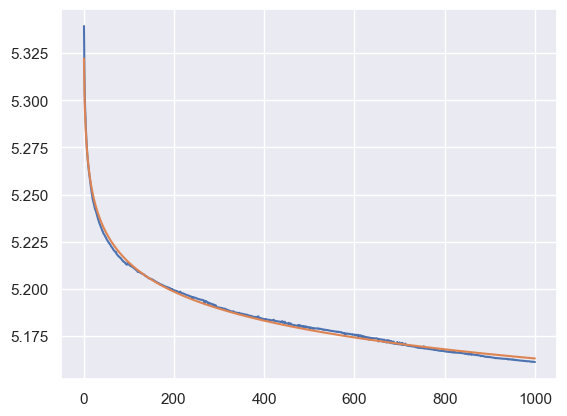

In [227]:
xray_stat_df = xray_stat_dfs[1]
a, b, c = fit_power_law_decay(xray_stat_df.index, xray_stat_df["{}_mean".format(score_field)])
plt.plot(xray_stat_df.index, xray_stat_df["{}_mean".format(score_field)], label="X-ray Score")
plt.plot(xray_stat_df.index, power_law_decay(xray_stat_df.index, a, b, c), label="Fitted Exponential Curve")

In [228]:

def find_derivative_zero_point_power_law(a, b, c, sigma, x_start=1.0):
    """
    Find the x value where the derivative of the power law decay function is approximately zero within a sigma value.

    Parameters:
    a (float): The scale factor in the power law equation.
    b (float): The exponent in the power law equation.
    c (float): The constant offset in the power law equation.
    sigma (float): The sigma value within which the derivative is considered approximately zero.
    x_start (float): The starting x value for finding the zero derivative point.

    Returns:
    x_zero_derivative (float): The x value where the first derivative is approximately zero within sigma.
    """

    # Define the derivative of the power law function
    def derivative_power_law(x):
        return a * b * np.power(x, b - 1)

    # Starting point for the search
    x_guess = x_start

    # Define the step size and precision for the search
    step_size = 0.1
    precision = sigma / 10  # Stop when we are within 10% of the sigma value

    # Search for the point where the derivative is approximately zero
    while abs(derivative_power_law(x_guess)) > sigma:
        # Update the guess based on the derivative
        x_guess -= step_size * np.sign(derivative_power_law(x_guess))

        # If the derivative changes sign, make the step size smaller
        if np.sign(derivative_power_law(x_guess - step_size)) != np.sign(derivative_power_law(x_guess)):
            step_size /= 10

        # If the step size is too small, break the loop
        if step_size < precision:
            break

    if abs(derivative_power_law(x_guess)) <= sigma:
        x_zero_derivative = x_guess
    else:
        x_zero_derivative = None  # Could not find a point where the derivative is approximately zero within sigma

    return x_zero_derivative


In [229]:
score_conv_pts = list()
acc_conv_pts = list()

for i in range(len(xray_stat_dfs)):
    xray_stat_df = xray_stat_dfs[i]
    rmsd_stat_df = rmsd_stat_dfs[i]

    a_score, b_score, c_score = fit_power_law_decay(xray_stat_df.index, xray_stat_df["{}_mean".format(score_field)])
    x_score = find_derivative_zero_point_power_law(a_score, b_score, c_score, sigma=1e-4)

    a_acc, b_acc, c_acc = fit_power_law_decay(rmsd_stat_df.index, rmsd_stat_df["{}_mean".format(rmsd_field)])
    x_acc = find_derivative_zero_point_power_law(a_acc, b_acc, c_acc, sigma=1e-4)

    score_conv_pts.append(x_score)
    acc_conv_pts.append(x_acc)

print(score_conv_pts)
print(np.mean(score_conv_pts), np.std(score_conv_pts))
print(acc_conv_pts)
print(np.mean(acc_conv_pts), np.std(acc_conv_pts))

[76.29999999999994, 222.99999999999162, 79.19999999999978, 82.99999999999956, 179.0999999999941, 110.09999999999802, 77.59999999999987, 77.39999999999988, 91.39999999999908, 149.5999999999958]
114.66999999999776 49.15862182770919
[29.30000000000015, 34.200000000000216, 21.700000000000042, 58.50000000000056, 53.00000000000048, 32.50000000000019, 30.70000000000017, 30.200000000000163, 32.30000000000019, 30.70000000000017]
35.31000000000023 10.765077798139838
